#### Author
Victor Aleksandrin

#### Reference
[Notion ticket](https://www.notion.so/a74951e4e815480584dea7d61ddce6cc?v=dbfdb1207d0e451b827d3c5041ed0cfd&p=7fd764a4d88643feb275ff4ab37911c6)

#### Idea
Build simple Hugging Face baseline. 

#### Data
4500 cryptonews titles labeled as positive, neutral or negative – [CSV](https://drive.google.com/file/d/1YqvAtWAQNeXvw-71TWtNmisAa9SN8gmj/view) (not to be shared outside of the project!)

#### Result
See the plot below. Cross-validation accuracy is increasing with data set size. Final accuracy of baseline model approx 79.2

In [1]:
from datasets import load_dataset, load_metric
from transformers import (
    DistilBertForSequenceClassification, DistilBertTokenizerFast, TrainingArguments, Trainer, 
    AdamW, get_scheduler
)

import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from typing import Dict, Any, Tuple, List

import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning import Trainer as Pl_trainer
from pytorch_lightning import seed_everything, Callback

import warnings
warnings.filterwarnings('ignore')

import logging
logging.disable(logging.INFO)
logging.disable(logging.WARNING)

seed_everything(42)

42

### Read data

In [2]:
DATA_PATH = '../data/20190110_train_4500.csv'

In [3]:
dataset = pd.read_csv(DATA_PATH)

In [4]:
dataset.head()

,title,sentiment
0,Bitcoin Market Has Run Out of Juice: Cryptocur...,Negative
1,Bitcoin Core 0.14.0 Speeds Up Blockchain Synci...,Positive
2,Thinking of Travelling With Bitcoin? With Thes...,Positive
3,Investors Carried Out Mental Gymnastics to Jus...,Negative
4,"Bitcoin Price Holds Above $8,500 as Market Fig...",Positive


In [5]:
dataset["label"] = LabelEncoder().fit_transform(dataset["sentiment"])

### Preprocess/split

In [6]:
class FinNewsDataset(Dataset):
    def __init__(self, encodings: Dict[str, Any], labels: list):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx: int) -> Dict[str, Any]:
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        
        return item
    
    def __len__(self) -> int:
        return len(self.labels)

In [7]:
def prepare_dataset(data: list, labels: list) -> Dataset:
    
    tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
    
    encodings = tokenizer(data, truncation=True, padding=True)
    
    return FinNewsDataset(encodings, labels)

In [8]:
def split_train_val(dataset: pd.DataFrame, test_size: float = 0.2) -> Tuple[list, ...]:
    train_data, val_data, train_labels, val_labels = train_test_split(
        dataset["title"].values, 
        dataset["label"].values,
        test_size=test_size
    )
    
    return train_data.tolist(), val_data.tolist(), train_labels.tolist(), val_labels.tolist()

In [9]:
train_data, val_data, train_labels, val_labels = split_train_val(dataset)

In [10]:
train_dataset = prepare_dataset(train_data, train_labels)
val_dataset = prepare_dataset(val_data, val_labels)

## Train pipeline

### Hugging Face api

In [11]:
def train_huggin_face_pipeline(
    model: DistilBertForSequenceClassification, 
    train_dataset: Dataset, 
    val_dataset: Dataset
):
    
    training_args = TrainingArguments(
        output_dir='./test_trainer',          # output directory
        num_train_epochs=3,              # total number of training epochs
        per_device_train_batch_size=16,  # batch size per device during training
        per_device_eval_batch_size=64,   # batch size for evaluation
        warmup_steps=500,                # number of warmup steps for learning rate scheduler
        weight_decay=0.001,             # strength of weight decay
        logging_steps=10,
        evaluation_strategy="epoch"
    )
    
    metric = load_metric("accuracy")
    
    def compute_metrics(eval_pred: tuple) -> dict:
    
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)

        return metric.compute(predictions=predictions, references=labels)
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )
    
    trainer.train()

In [12]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

In [13]:
train_huggin_face_pipeline(model, train_dataset, val_dataset)

Epoch,Training Loss,Validation Loss,Accuracy
1,0.663500,0.586904,0.770582
2,0.597800,0.561894,0.791438
3,0.329800,0.609911,0.793633


### Pytorch-Lightning api

In [14]:
class SentimentPipeline(pl.LightningModule):
    """Class for training text classification models"""

    def __init__(self, model, num_training_steps: int):
        super().__init__()

        self.model = model
        self.metric = load_metric("accuracy")
        self.num_training_steps = num_training_steps
        
        self.metrics = []

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=5e-5)

        lr_scheduler = get_scheduler(
            name="linear",
            optimizer=optimizer,
            num_warmup_steps=500,
            num_training_steps=self.num_training_steps,
        )

        scheduler = {
            "scheduler": lr_scheduler,
            "interval": "step",
            "frequency": 1,
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler}

    def training_step(self, batch: Dict[str, Tensor], batch_idx: int) -> Tensor:

        outputs = self.model(**batch)
        
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        self.metric.add_batch(predictions=predictions, references=batch["labels"])
        
        self.log(
            "train_acc",
            self.metric.compute()["accuracy"],
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=False,
        )
        
        self.log(
            "train_loss",
            outputs.loss,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=False,
        )
        
        return outputs.loss

    def validation_step(self, batch: Dict[str, Tensor], batch_idx: int) -> None:

        with torch.no_grad():
            outputs = self.model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        self.metric.add_batch(predictions=predictions, references=batch["labels"])
        
        self.log(
            "val_acc",
            self.metric.compute()["accuracy"],
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=False,
        )
        
        self.log(
            "val_loss",
            outputs.loss,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=False,
        )

In [15]:
class MetricTracker(Callback):

    def __init__(self):
        self.collection = {
            "train_loss": [],
            "val_loss": [],
            "train_acc": [],
            "val_acc": []
        }
    
    def _log_metrics(self, trainer, stage: str = "train"):
        for key in (f"{stage}_acc", f"{stage}_loss"):
            self.collection[key].append(trainer.callback_metrics[key].item())
        
    def on_validation_epoch_end(self, trainer, module):
        self._log_metrics(trainer, "val")
    
    def on_train_epoch_end(self, trainer, module):
        self._log_metrics(trainer, "train")

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [17]:
def train_pl_model(model, train_dataloader, val_dataloader) -> Dict[str, Any]:
    num_epochs = 3
    num_training_steps = num_epochs * len(train_dataloader)
    
    pipeline = SentimentPipeline(
        model,
        num_training_steps
    )
    
    metric_tracker = MetricTracker()
    trainer = Pl_trainer(
        max_epochs=num_epochs,
        gpus=1,
        callbacks=[metric_tracker],
        num_sanity_val_steps=0
    )

    trainer.fit(
        pipeline, 
        train_dataloaders=train_dataloader, 
        val_dataloaders=val_dataloader
    )
    
    return metric_tracker.collection

In [18]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

In [19]:
scores = train_pl_model(model, train_dataloader, val_dataloader)

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [20]:
scores

{'train_loss': [0.8528251051902771, 0.5094258189201355, 0.30248430371284485],
 'val_loss': [0.5610117316246033, 0.5404676198959351, 0.5668961405754089],
 'train_acc': [0.6113093495368958, 0.8048312067985535, 0.8932198882102966],
 'val_acc': [0.7859495282173157, 0.794731080532074, 0.7958287596702576]}

### Cross-validation

In [21]:
def cross_val(dataset: pd.DataFrame, model, n_splits: int = 3, shuffle: bool = True) -> List[float]:
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=17)
    
    data = dataset["title"].values
    labels = dataset["label"].values
    
    cv_accuracy = []
        
    for train_index, test_index in skf.split(data, labels):
        fold_model = deepcopy(model)
        
        train_data, val_data = data[train_index], data[test_index]
        train_labels, val_labels = labels[train_index], labels[test_index]
        
        train_dataset = prepare_dataset(train_data.tolist(), train_labels.tolist())
        val_dataset = prepare_dataset(val_data.tolist(), val_labels.tolist())
        
        train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
        
        scores = train_pl_model(fold_model, train_dataloader, val_dataloader)
        
        cv_accuracy.append(scores["val_acc"][-1])
    
        torch.cuda.empty_cache()
    
    return cv_accuracy

In [22]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
cv_accuracy = cross_val(dataset, model)

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [23]:
np.mean(cv_accuracy), np.std(cv_accuracy)

(0.7938076257705688, 0.0009316139394848017)

## Val Learning Curve

In [24]:
def learning_curve(model, dataset: pd.DataFrame, train_fracs: np.ndarray):
    
    train_sizes = []
    val_scores = []
    
    num_points: int = len(train_fracs)
    
    for i in range(num_points):
        
        num_samples = int(len(dataset)*train_fracs[i])
        
        train_data = dataset[:num_samples]
        
        cv_score = cross_val(train_data, model)
        
        val_scores.append(cv_score)
        train_sizes.append(num_samples)
    
    return train_sizes, val_scores

In [25]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
train_sizes, val_scores = learning_curve(model, dataset, np.linspace(.2, 1, 5))

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [26]:
# helper function

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

In [28]:
np.array(val_scores).mean(1)

array([0.5297066 , 0.7265239 , 0.75256431, 0.77902681, 0.79270971])

Text(0.5, 1.0, '4500 titles. DistilBert learning curves')

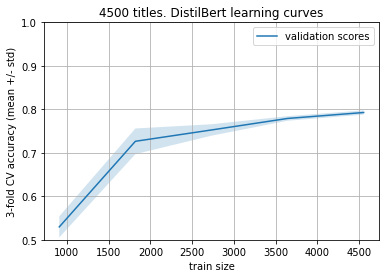

In [27]:
plot_with_err(train_sizes, np.array(val_scores), label='validation scores')
plt.xlabel('train size')
plt.ylabel('3-fold CV accuracy (mean +/- std)')
plt.legend()
plt.grid(True);
plt.ylim(.5, 1)
plt.title('4500 titles. DistilBert learning curves')